<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

In [8]:
pip install umap-learn

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer
import os
import tarfile

import tensorflow as tf

%matplotlib inline
import umap
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [5]:
import os
import tensorflow as tf
import tarfile
import os
from packaging import version
import shutil
import sys

def download_and_extract_data(
    url="https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz",
    target_dir="data",
    fname="colab_material.tgz",
    update_folder=False
):
    """Download and extract a tar.gz dataset into target_dir."""

    if update_folder and os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    if not os.path.exists(target_dir):
        cache_dir = os.path.abspath(".")

        if version.parse(tf.__version__) >= version.parse("2.13.0"):
            # new behavior: fname must be only a filename
            path = tf.keras.utils.get_file(
                fname=fname,
                origin=url,
                cache_dir=cache_dir
            )
        else:
            # old behavior: can pass full path
            path = tf.keras.utils.get_file(
                fname=os.path.join(cache_dir, fname),
                origin=url
            )
        # extract tar into target_dir
        with tarfile.open(path, "r:gz") as tar:
            tar.extractall(target_dir)
    else:
        print('Data already present. Use update_folder = True to overwrite/update if desired.')
    return os.path.abspath(target_dir)

data_path = download_and_extract_data(update_folder=False)
sys.path.append(data_path)
print("Data available at:", data_path)

2256996/2256996 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data available at: /content/data


/tmp/ipython-input-680218323.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(target_dir)


In [9]:
from utils.routines import *

In [10]:
import pickle

def get_nlp_dataset(data_path='/content/data'):
    data=pickle.load(open(f'{data_path}/data/cluster_nlp.pkl', 'rb'))
    vectors=data['embeddings']
    texts=data['texts']
    return texts, vectors

def get_customers_dataset(data_path='/content/data'):
    X_customers = pd.read_csv(f'{data_path}/data/X_customers.csv')
    return X_customers

**CLUSTERING Objective:**

Clustering techniques divide the set of data into group of points having common features. Each data point $p$ gets assigned a label $l_p \in \{1,..,K\}$ representing the group to which it belongs.

In this presentation the starting data points (data-cloud) are supposed to have $D$ features.

**General Caveat:**

Clustering techniques rely on a a-priori fixed notion of 'distance' between the points. This implies:

- The default distance is called `euclidean`: $d(x_p,x_{q})=\sqrt{\sum_{i} |x_{p,i}-x_{q,i}|^{2}}$. This distance is not invariant if we change units, if all features have difference units. If we want to use the the default euclidean distance when performing data analysis we should normalize variables beforehand.

- Other ad-hoc distances may be defined depending on the use-case scenario.

- Results of clustering must always be checked by experts of the field of interest. Clustering data therefore is an iterative process that requires trying out different type of techniques.

Note that if your data is labelled (e.g. each label is assigned to a class), the number of groups/clusters can be different than the number of classes. There is no reason that these numbers should be equal.

## 1. K-Means

Consider first that you know the number of groups over which you want to divide your data. For example $K=3$ or $K=10$ groups.

***-cluster centers***

K-means heavily relies on the concept of:

`cluster centers`. Each group gets assigned a cluster center, as a mean representative point. The centroids given by the expression:
$$\mathbf{c}_k=\frac{1}{N_k}\sum_{p \in S_k} \mathbf{x_p}$$

, $S_k$ is the subset of points assigned to the same group $k$ and $N_k$ is the number of points in $S_k$.

If the data cloud is made of images, it is the image containing at each pixel the mean value of all images of that group.

If the data cloud is made of questionnaires, it is the mean value assigned to an answer by all questionnaires belonging to that group.

If the data cloud is made of pressure sensors, it assigns to each sensors the mean of the pressure over all time spans belonging to that group, and so on...

$K-Means$ assign cluster center to a single group. All points whose closest cluster center belongs to class $K$, is assigned to group $K$ as well.


***-loss function***

The cluster centres are chosen in order to minimize the following loss function:

$$\sum_{k \in \text{classes}} \sum_{p \in S_k} d(\mathbf{x}_p,\mathbf{c}_{k})^2$$

where $S_k$ is the subset of points assigned to the same group $k$.

d is the metric function suited of the problem of interest. Here we use the Euclidean distance as a metric :

$$d(\mathbf{x}_p,\mathbf{c}_{k})=|\mathbf{x}_p-\mathbf{c}_{k}| \quad \quad $$


Such an algorithm finds local minima and may need to be started several times with different initializations.

**-vary the number of classes and validate the clustering**

*Silhouette score*: K-means clustering fixes the number of clusters a priori. Some technique must be chosen to score the different optimal clusterings for different $k$. One technique chooses the best *Silouhette score*. Intuitively, this evaluates the typical distance of points within a same clusters and compares it against the typical distance of points belonging to neighboring but different clusters ( https://en.wikipedia.org/wiki/Silhouette_(clustering) ).


### Sklearn: implementation and usage of K-means.

We start with a 2D example that can be visualized.

First we load the data-set.

In [ ]:
points=km_load_th1()

Explore the data-set checking the dataset dimensionality.

In [ ]:
print(points.shape)
print('We have ', points.shape[0], 'points with two features')

(120, 2)
We have  120 points with two features


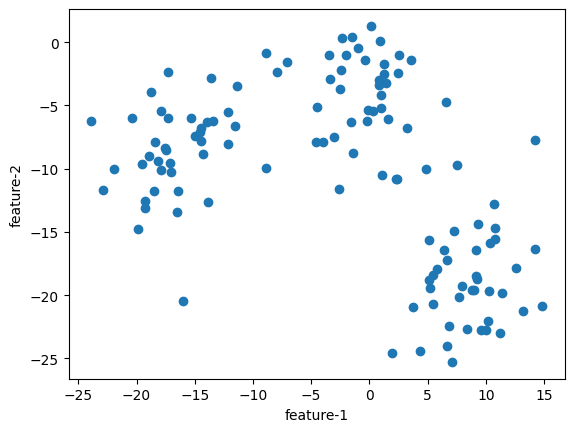

In [ ]:
plt.plot(points[:,0],points[:,1],'o')
plt.xlabel('feature-1')
plt.ylabel('feature-2')
plt.show()

It looks visually that the data set has three clusters. We will cluster them using K-means. As usual, we create a KMeans object. Note that we do not need to initialize it with a data-set.

In [ ]:
clusterer = KMeans(n_clusters=3, random_state=10, n_init=10)

A call to the fit method computes the cluster centers which can be plotted alongside the data-set. They are accessible from the cluster_centers_ attribute:

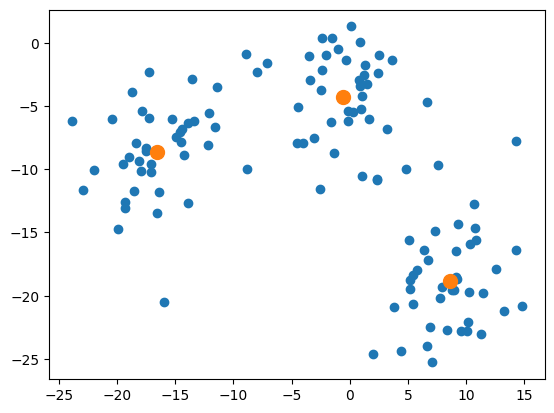

In [ ]:
clusterer.fit(points)
plt.plot(points[:,0],points[:,1],'o')
plt.plot(clusterer.cluster_centers_[:,0],clusterer.cluster_centers_[:,1],'o',markersize=10)
plt.show()

In [ ]:
clusterer.cluster_centers_[:,:]

array([[  8.5901409 , -18.82448838],
       [-16.59659661,  -8.6652939 ],
       [ -0.62089021,  -4.27748903]])

The predict method assigns a new point to the nearest cluster. We can use predict with the training dataset and color the data-set according to the cluster label.

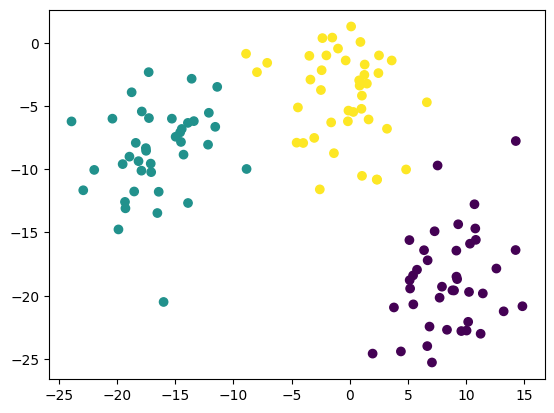

In [ ]:
cluster_labels=clusterer.predict(points)
plt.scatter(points[:,0],points[:,1],c=cluster_labels)
plt.show()

Finally, we can try to vary the number of clusters and score them with the Silhouette score.

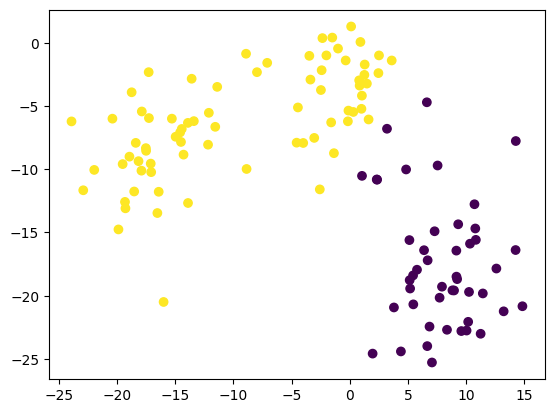

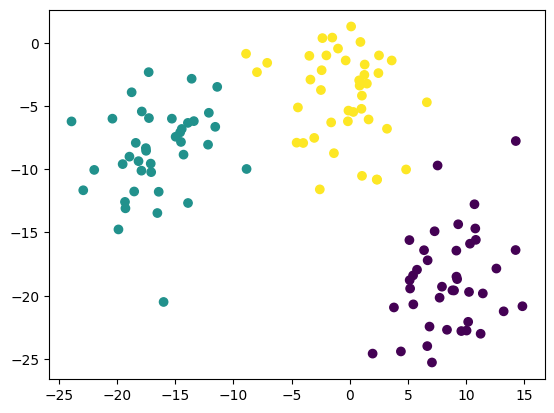

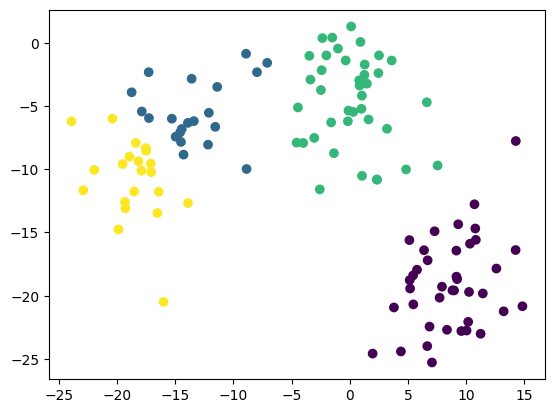

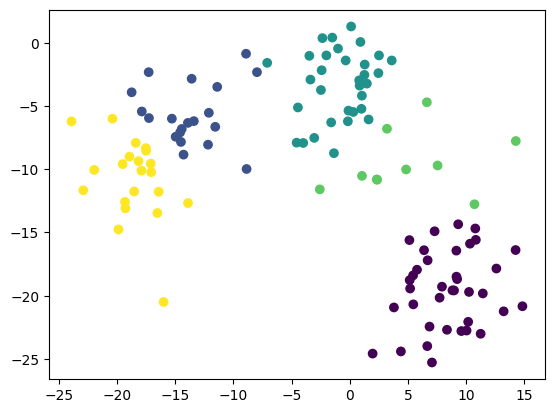

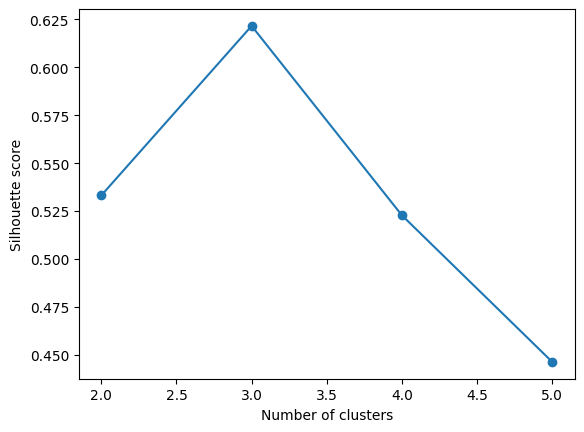

In [ ]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(points)
    score=silhouette_score(points,cluster_labels)
    sil.append(score)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    plt.show()

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()

The same techniques can be used on high dimensional data-sets. We use here the famous MNIST dataset for integer digits, that we are downloading from tensorflow.

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

X=train_images[:5000,:].reshape(5000,-1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(5000, 784)


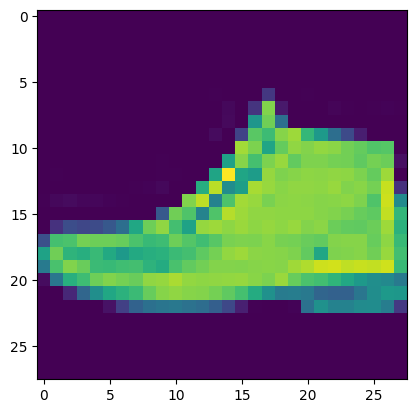

In [ ]:
print(X.shape)
image=X[1232,:].reshape(28,28)
plt.imshow(image)

We can cluster the images exactly as we did for the 2d dataset.

In [ ]:
clusterer = KMeans(n_clusters=10, random_state=10, n_init=10)
cluster_labels = clusterer.fit_predict(X)

We can plot the cluster centers (which are 2D figures!) to see if the clustering is learning correct patterns!

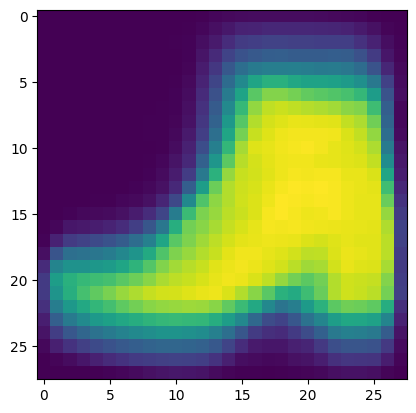

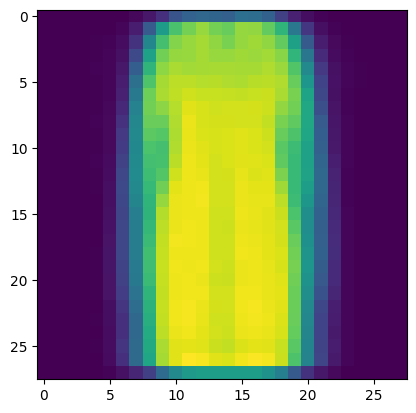

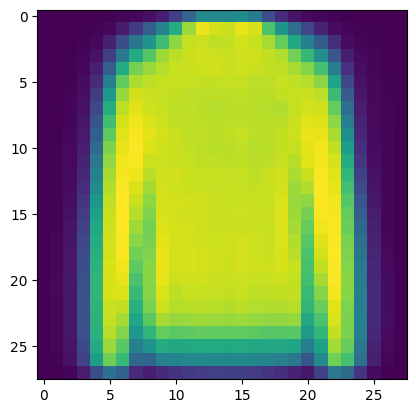

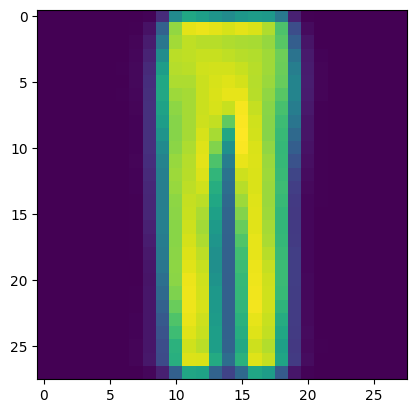

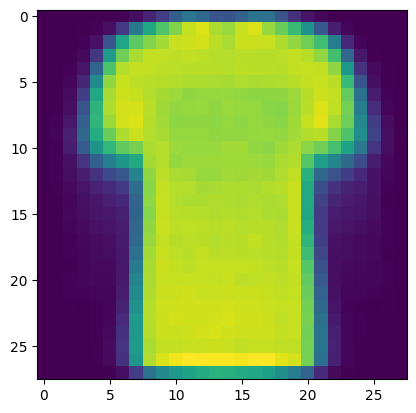

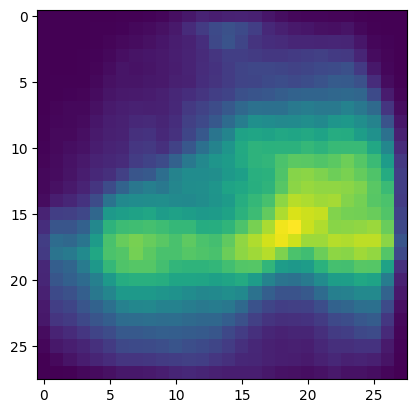

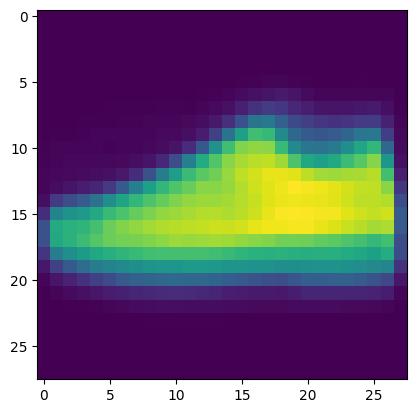

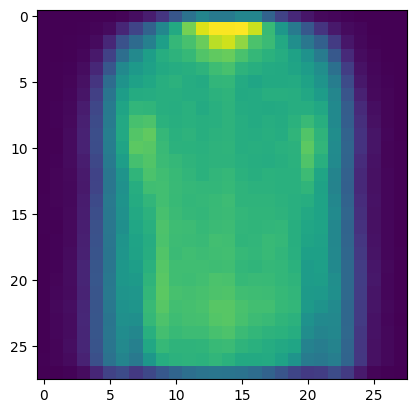

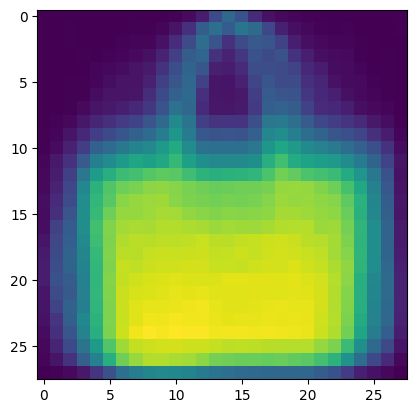

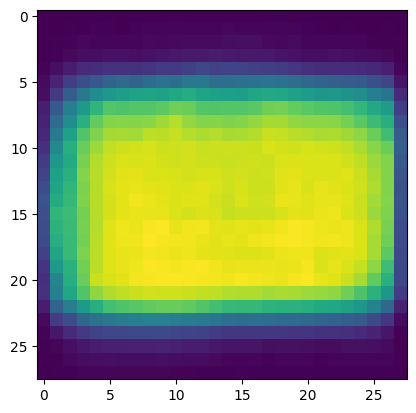

In [ ]:
for iclust in range(10):
    plt.imshow(clusterer.cluster_centers_[iclust].reshape(28,28))
    plt.show()

You can see that the model is trying to assign one class to each group.

### EXERCISE 1: Guess themes in an NLP dataset

In [ ]:
texts, vectors = get_nlp_dataset()

In [ ]:
vectors

array([[-2.30204761e-02, -1.45834382e-03,  6.07466651e-03, ...,
         4.02899081e-04, -6.34306198e-05, -5.75837959e-03],
       [-5.12431981e-03, -1.23818405e-02,  1.52636496e-02, ...,
         1.07720029e-02, -8.02269112e-03,  4.06434434e-03],
       [-1.19518172e-02,  8.96220037e-04, -2.27962458e-03, ...,
         4.35971981e-03, -8.20066221e-03, -2.09505986e-02],
       ...,
       [-1.48468791e-02,  1.12261642e-02,  1.08621428e-02, ...,
         5.45057282e-03,  1.44568561e-02, -1.84935948e-03],
       [ 3.41629726e-03, -1.15026502e-04, -2.06904812e-03, ...,
        -3.86701338e-03, -9.65446979e-03, -3.92710902e-02],
       [-4.75275749e-03, -7.96011928e-03,  2.03699116e-02, ...,
        -1.39218830e-02, -8.73281714e-03, -1.15438383e-02]])

In [ ]:
vectors.shape

(235, 1536)

In [ ]:
# Assign the optimal number of clusters and fit the KMeans model
optimal_n_clusters = optimal_clusters # Use the optimal number of clusters found earlier
clusterer = KMeans(n_clusters=optimal_n_clusters, random_state=10, n_init=10)
cluster_labels = clusterer.fit_predict(embedding)

# Add the cluster labels to the texts
clustered_texts = list(zip(texts, cluster_labels))

# Print a few examples from each cluster
for i in range(optimal_n_clusters):
    print(f"Cluster {i+1} examples:")
    cluster_examples = [text for text, label in clustered_texts if label == i][:5] # Get up to 5 examples
    for text in cluster_examples:
        print(f"- {text}")
    print("-" * 20)

Cluster 1 examples:
- A hockey forward practiced puck control and quick release shots to increase scoring chances during power plays.
- The track team tapered volume leading up to the finals to ensure athletes felt fresh and explosive on race day.
- The rowing crew synchronized strokes perfectly on the misty river as they raced against rival teams for the championship.
- The sport psychologist helped a veteran player overcome performance anxiety and reclaim confidence before the playoffs.
- A spirited rivalry game drew record attendance, with alumni returning to root for their old school under bright lights.
--------------------
Cluster 2 examples:
- Virtual assistants became more common in households, helping users schedule tasks and control devices.
- The tech giant introduced stricter privacy controls after public backlash over user data policies.
- The university offered online courses in data science, machine learning, and software engineering to meet job demand.
- Data analysts c

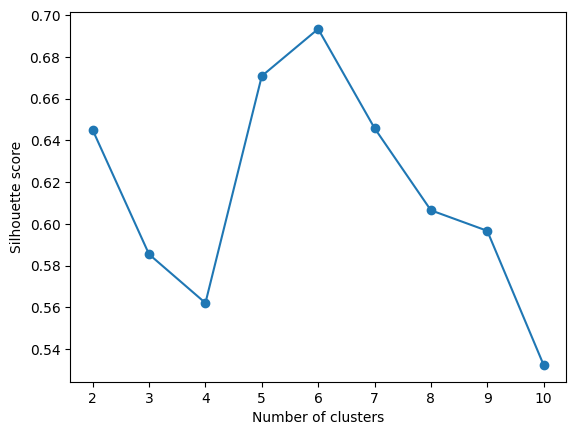

Optimal number of clusters based on silhouette score: 6


In [ ]:
sil = []
max_clusters = 10 # You can adjust this range as needed

# Iterate over a range of cluster numbers
for n_clusters in range(2, max_clusters + 1):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(embedding)
    score = silhouette_score(embedding, cluster_labels)
    sil.append(score)

# Plot the silhouette scores
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil)) + 2, sil, '-o')
plt.show()

# Find the optimal number of clusters based on the maximum silhouette score
optimal_clusters = np.argmax(sil) + 2
print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")

In [ ]:
reducer = umap.UMAP(metric='cosine')
embedding = reducer.fit_transform(vectors)

In [ ]:
texts

['Virtual assistants became more common in households, helping users schedule tasks and control devices.',
 'The tech giant introduced stricter privacy controls after public backlash over user data policies.',
 'A solar observatory tracked a series of coronal mass ejections and assessed their likely impacts on satellites.',
 'The dentist taught children proper brushing and flossing habits during their annual checkup.',
 'A hockey forward practiced puck control and quick release shots to increase scoring chances during power plays.',
 'A journalist covered the campaign trail, reporting on candidates’ promises and voter reactions.',
 'The home cook built a spice rack organized by cuisine type, making it easier to grab ingredients for international recipes.',
 'At the culinary school, students learned molecular gastronomy principles to create playful textures and surprising flavor pairings.',
 'A team published evidence for seasonal methane releases on a nearby planet, sparking discussion

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


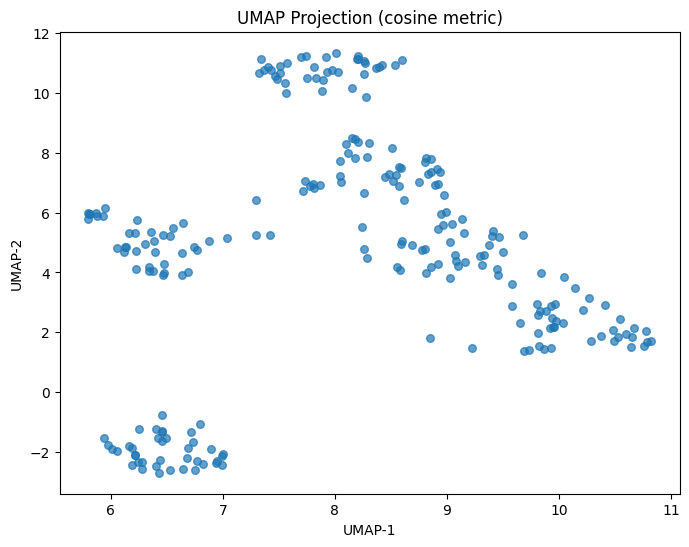

Optimal number of clusters: 6


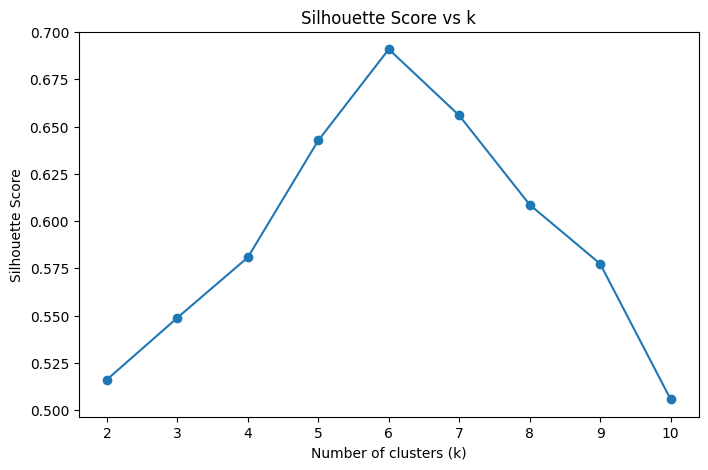

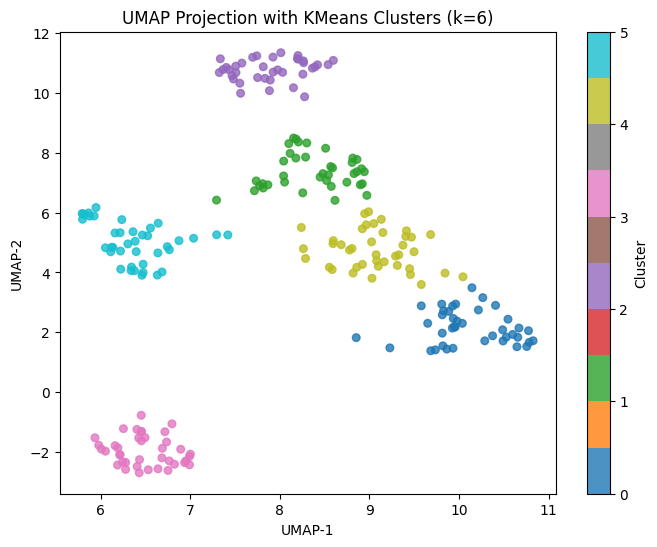

ValueError: All arrays must be of the same length

In [ ]:
# 1. Explore the dataset


# 2. Perform a umap projection of the vectors (see Course 2). Use metric='cosine'
# Create UMAP reducer with cosine similarity
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine", random_state=42)

# Fit and transform
embedding = reducer.fit_transform(vectors)  # shape = (235, 2)

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1], s=30, alpha=0.7)
plt.title("UMAP Projection (cosine metric)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

# 3. Perform a clustering of the projected vectors. Get the optimal number of clusters with the sihouette score.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 'embedding' is the UMAP 2D projection with shape (235, 2)

# Try different numbers of clusters
range_n_clusters = range(2, 11)  # test between 2 and 10 clusters
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embedding)
    score = silhouette_score(embedding, cluster_labels)
    silhouette_scores.append(score)

# Pick the best number of clusters
optimal_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Fit final KMeans with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embedding)

# Plot silhouette scores
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.show()

# Plot UMAP with cluster colors
plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1], c=cluster_labels, cmap="tab10", s=30, alpha=0.8)
plt.title(f"UMAP Projection with KMeans Clusters (k={optimal_k})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster")
plt.show()

# 4. Try to guess the themes of the clusters by looking at the texts in each cluster.
import pandas as pd

# Suppose you have a list of original texts aligned with your vectors
texts = [...]  # length = 235

# Create DataFrame for inspection
df = pd.DataFrame({
    "text": texts,
    "cluster": cluster_labels
})

# Preview a few texts per cluster
for k in sorted(df["cluster"].unique()):
    print(f"\n--- Cluster {k} ---")
    print(df[df["cluster"] == k]["text"].head(5).to_list())

# 5. Upload here https://docs.google.com/document/d/1f5sDOS_cq1_ZaUkwlSnog5I8jpYiK_QAF1hk3vcBFL8/edit?usp=sharing the number of clusters you found and the themes you guessed.
#number of clusters: 6
#themes guessed: sports, AI, cooking, politics, space exploration, healthcare


## 3. Dendograms (hierarchical clustering)

**Objective:**

In hierarchical clustering we do not have only an optimal set of clusters, but for each different "length scale" we have a different set of clusters.

**Algorithm:**

- We start with a length scale $l=0$ at the beginning and consider all sample elements as different clusters.

- We increase than $l$ to values larger than zero. Let's call the minimum distance between pair of points $l_0$. As soon as we reach $l=l_0$, these elements are merged into a new cluster (greedy strategy).

To proceed further we need to define a distance between subsets $S_1,S_2$ of points. In the "single linkage" flavour we define:

$$d(S_1,S_2)=min_{a\in S_1, b\in S_2} d(a,b)$$

IMPORTANT: other linkage procedure exists. Check each time the documentation to see which is the default one if you did not specify it. Results may be dependent on the linkage criterion.

- This way we can proceed increasing $l>l_0$. As soon as we find two clusters with distance smaller than $l_1>l_0$, we merge them.

- We keep on increasing $l$ as far as one one cluster remains

The result of this clustering procedure can be summarized in a `dendrogram` . We demonstrate a dendogram using our 2D dataset but keep in mind that the right plot of the following visualization can be done also in higher dimensions, i.e. when you have more than 2 features, but the left plot is not straightforward (convince yourself why).

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy
from ipywidgets import interact
from scipy.cluster.hierarchy import fcluster

points=km_load_th1()
Z = hierarchy.linkage(points, 'single')
n_clusters=int(np.max(Z[:,[0,1]].flatten()))
print(n_clusters)

@interact
def plot(t=(0,7,0.1)):
    fig, axes=plt.subplots(1,2,figsize=(15,10), gridspec_kw={'width_ratios': [1, 2]})
    fl = fcluster(Z,t=t,criterion='distance')
    maps={}
    for clust in range(n_clusters):
        maps[clust]=(fl==clust)
    c=0
    for clust in range(n_clusters):
        if np.sum(maps[clust])>0:
            c+=1
    plt.figure(figsize=(19,5))
    d = hierarchy.dendrogram(Z,ax=axes[1], color_threshold=t)
    axes[1].axhline(t,linestyle='--',color='red')
    axes[1].set_ylabel('Cluster distance')
    axes[1].axes.get_xaxis().set_visible(False)
    axes[1].set_xlabel('Points')
    axes[1].set_title(f'Number clusters: {c}')
    axes[0].scatter(points[d['leaves'],0],points[d['leaves'],1], color=d['leaves_color_list'])
    plt.show()

237


interactive(children=(FloatSlider(value=3.0, description='t', max=7.0), Output()), _dom_classes=('widget-inter…

**Properties:**

If we fix a certain cutoff length $l_c$, the clusters identified $C_1,...,C_n$ at that length are such that :

1- The constintute a disjoint partition of the whole dataset, i.e. they are mutually non intersecting aand each point belongs to a cluster

2- The distance between two clusters $d(C_1,C_j)$ is larger than $l_c$ for each $i,j$.


### EXERCISE 2: Explore feature correlation using dendograms

The `points` when using dendograms can be any set of objects over which we can define a distance. They do not need to be the original dataset.

Often dendograms are used to visualize the correlation between feature, which is the goal of this exercise.

Let's load a dataset of customers interactions in relation to an online program.

This analysis can be useful when trying to interpret the output of a model.

In [ ]:
df=get_customers_dataset()

In [ ]:
df

,Sales calls,Interactions,Economy,Last upgrade,Discount,Monthly usage,Ad spend,Bugs reported
0,2.0,2.0,0.719054,17.036984,0.283774,0.825265,0.803090,1.0
1,3.0,3.0,0.188017,13.464172,0.059483,0.287509,0.275391,0.0
2,2.0,2.0,0.387437,1.631930,0.167273,0.433489,1.396768,1.0
3,2.0,2.0,0.866165,7.710981,0.330207,0.235349,0.218303,0.0
4,2.0,2.0,0.585444,6.391478,0.299390,0.824211,0.815360,1.0
...,...,...,...,...,...,...,...,...
9995,2.0,3.0,0.715427,10.540743,0.373957,0.373962,0.363134,0.0
9996,2.0,2.0,0.564662,1.878001,0.305935,0.543083,1.521588,0.0
9997,3.0,3.0,0.290156,11.794950,0.376242,0.245795,0.224300,0.0
9998,0.0,1.0,0.989440,12.251466,0.280882,0.271200,0.255873,0.0


In [3]:
# 1. Inspet the dataset
# 2. Perform hierarchical clustering using the "distance" 1-|r| (not really a distance), where r is the correlation coefficient
# 3. Adapt the code to visualize the dendrogram in this case. You may find the following function helpful:

def get_Z_matrix_from_distance_matrix(dist_matrix, method='single'):
    """
    Perform hierarchical clustering using linkage on a distance matrix. The output of this function can be an input of the dendrogram function

    Parameters
    ----------
    dist_matrix : np.ndarray
        A square distance matrix (n_features x n_features).
    method : str, optional
        Linkage method to use (default is 'single'). See scipy.cluster.hierarchy.linkage for options.

    Returns
    -------
    Z : np.ndarray
        The linkage matrix for hierarchical clustering.
    """
    condensed_dist = squareform(dist_matrix, checks=False)
    Z = linkage(condensed_dist, method=method)
    return Z

# 4. Inspect the correlation between the figures. Are they stable if you change the linkage criterion?


## 4. Gaussian mixtures (soft clustering)

### Theory overview.

K-Means is a modelling procedure which is biased towards clusters of circular shape and therefore does not always work perfectly, as the following examples show:

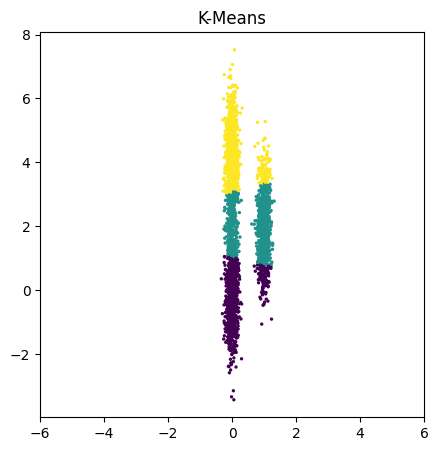

In [11]:
points=gm_load_th1()
clusterer = KMeans(n_clusters=3, random_state=10, n_init=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

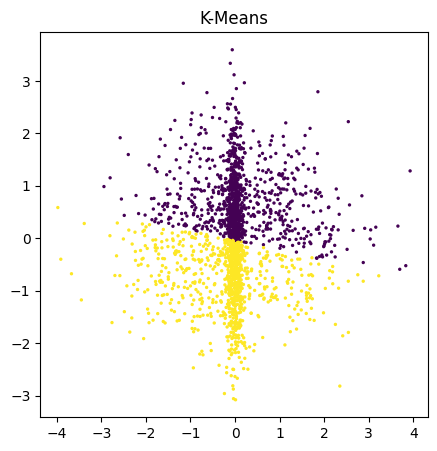

In [12]:
points=gm_load_th2()
clusterer = KMeans(n_clusters=2, random_state=10, n_init=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.title('K-Means')
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

A Gaussian mixture model is able to fit these kinds of clusters. In a Gaussian mixture model, each point of the distribution is supposed to be a random point from a distribution given by a superposition of Gaussians:

$$f(\mathbf{x})=\sum_c \pi_c N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$$

Each Gaussian describes the shape of each group, that may be also non spherical or tilted.

This density has the following interpretation. Suppose each data point $\hat{X}$ results from the following 2-step procedure:

1- First choose a random number between $\{1,...,N_c\}$ using some prior probabilities $\{\pi_1,...\pi_{N_c}\}$. This random variable says to what group a the point belong.

2- Now we extract the features corresponding to that point $\hat{X}$ using the corresponding density $N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$.

The parameters $\{\pi_c,\mathbf{\mu_c},\mathbf{\Sigma_c}\}$ are fitted from the data using a minimization procedure (maximum likelihood via the EM algorithm) and $N_c$ is the chosen number of clusters.



**Output of a GM computation:**

Given the features of a new point we can reverse engineer the probability that this point was extracted one group or the other.

- *Cluster probabilities:* A gaussian mixtures model is an example of soft clustering, where each data point $p$ does not get assigned a unique cluster, but a distribution over clusters $f_p(c), c=1,...,N_c$.

- *AIC/BIC:* after each clustering two numbers are returned. These can be used to select the optimal number of Gaussians to be used, similar to the Silhouette score. ( AIC and BIC consider both the likelihood of the data given the parameters and the complexity of the model related to the number of Gaussians used ). The lowest AIC or BIC value is an indication of a good fit.

### Sklearn: implementation and usage of Gaussian mixtures

First of all, we see how the Gaussian model behaves on our original example:

2 1592.1418091070063 1622.804218277609


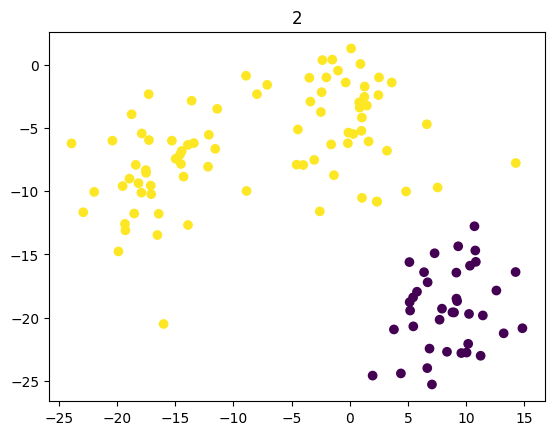

3 1550.4974051432473 1597.884764770542


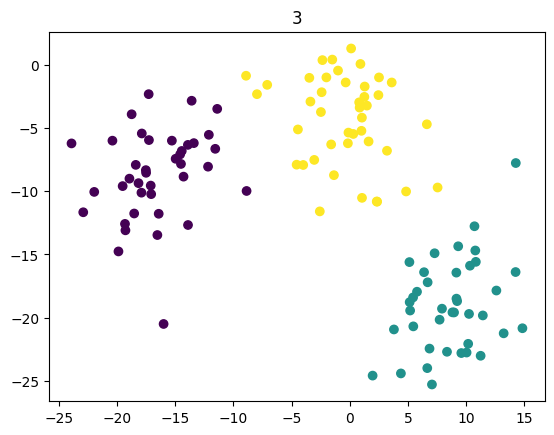

4 1560.7956890318683 1624.9079991158553


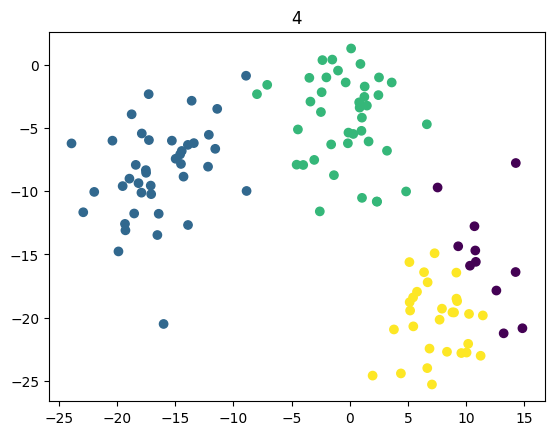

5 1566.1196297096371 1646.9568902503165


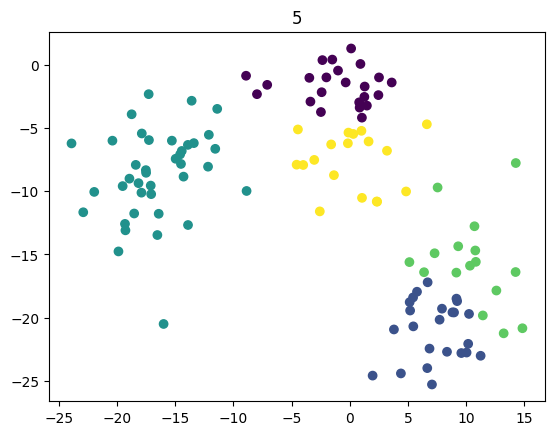

In [13]:
points=km_load_th1()

aic=[]
bic=[]
sil=[]

for i_comp in range(2,6):
    plt.figure()
    plt.title(str(i_comp))
    clf = GaussianMixture(n_components=i_comp, covariance_type='full')
    clf.fit(points)
    cluster_labels=clf.predict(points)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    print(i_comp,clf.aic(points),clf.bic(points))
    score=silhouette_score(points,cluster_labels)
    aic.append(clf.aic(points))
    bic.append(clf.bic(points))
    sil.append(score)
    plt.show()

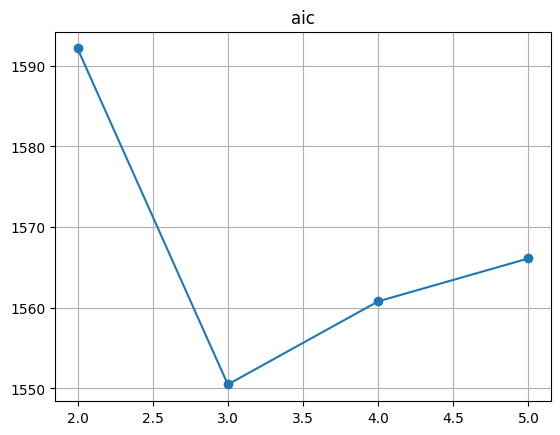

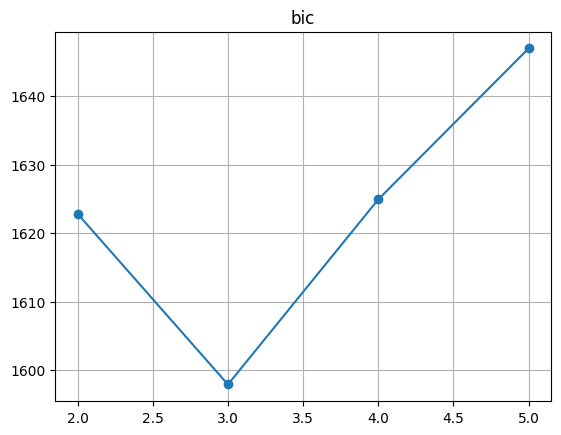

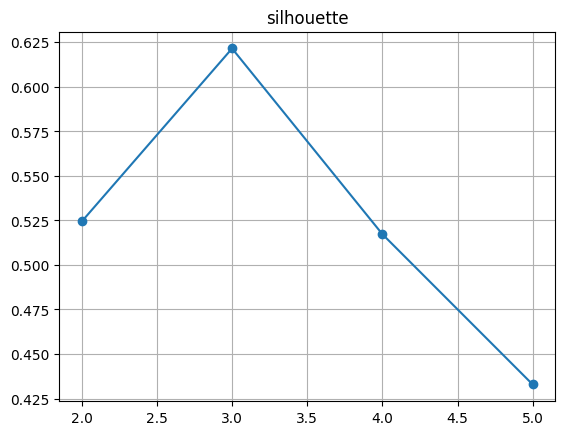

In [14]:
plt.plot(np.arange(2,6),aic,'-o')
plt.title('aic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),bic,'-o')
plt.title('bic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),sil,'-o')
plt.title('silhouette')
plt.grid()
plt.show()

So in this case we get a comparable result, and also the probabilistic tools agree with the Silhouette score ! Let's see how the Gaussian mixtures behave in the examples where K-means was failing.

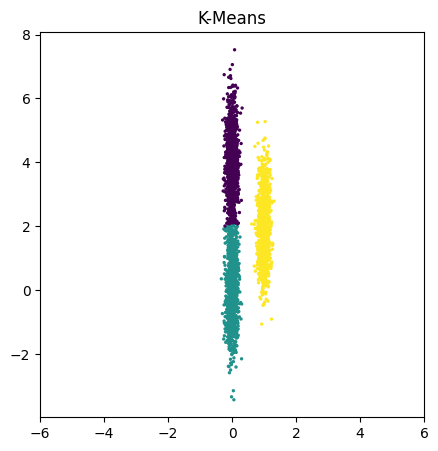

In [15]:
points=gm_load_th1()
clf = GaussianMixture(n_components=3, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

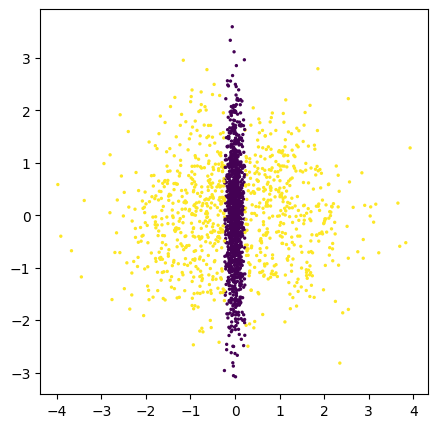

In [17]:
points=gm_load_th2()
clf = GaussianMixture(n_components=2, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

### EXERCISE 3: Find the cluster uncertainty with Gaussian mixtures

In [16]:
#In this exercise you need to load the dataset used to present K-means ( def km_load_th1() ) or the one used to discuss
# the Gaussian mixtures model ( def gm_load_th1() ).
#As discussed, applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point,
#but also a probability distribution over the clusters.

#From this probability distribution, you can compute for each point the entropy of the corresponging
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction.
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

# In detail you shoud:
# 1. Instantiate a GaussianMixture object with the number of clusters that you expect
# 2. fit the object on the dataset with the fit method

points=gm_load_th1()

plt.figure()
clf = GaussianMixture(..., covariance_type='full')
clf...(...)

# 3. compute the cluster probabilities using the method predict_proba. This will return a matrix of
# dimension npoints x nclusters (check that this is the case!)
# 4. use the entropy function ( from scipy.stats you need to import the entropy
# function ) to evaluate for each point the uncertainty of the
#prediction. Check here if in doubt: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

cluster_labels_prob=...

from ... import ...
entropies=[]
for point in range(len(...)):
    entropies.append(...)

# 5. Plot the points colored accordingly to their uncertanty.

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)


SyntaxError: invalid syntax (ipython-input-1786220549.py, line 18)

/tmp/ipython-input-1921611014.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


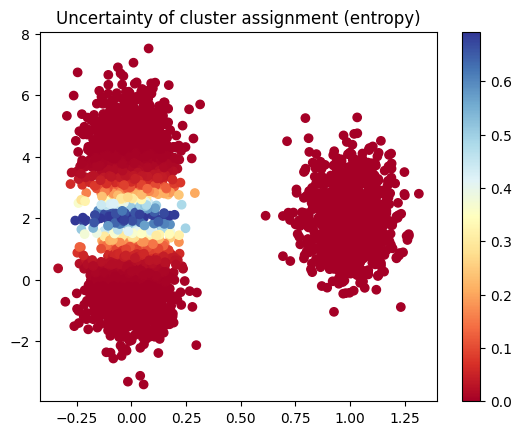

In [18]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy

# load the dataset (choose the Gaussian mixtures one as asked in the exercise)
points = gm_load_th1()

plt.figure()

# 1. Instantiate a GaussianMixture object with the expected number of clusters
#    (let’s assume we expect 3 clusters; adjust if needed)
clf = GaussianMixture(n_components=3, covariance_type='full')

# 2. Fit the object on the dataset
clf.fit(points)

# 3. Compute the cluster probabilities for each point
cluster_labels_prob = clf.predict_proba(points)  # shape: (n_points, n_clusters)

# 4. Compute the entropy of the probability distribution for each point
entropies = []
for i in range(len(points)):
    entropies.append(entropy(cluster_labels_prob[i]))

# 5. Plot the points colored accordingly to their uncertainty
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:, 0], points[:, 1], c=entropies, cmap=cm)
plt.colorbar(sc)
plt.title("Uncertainty of cluster assignment (entropy)")
plt.show()


# Final notes

### Note 1: More clustering methods.

 We covered here the most basic clustering techniques, showcasing different behaviors. For real like projects, there are also other algorithms that could be taken into consideration, e.g. a popular algorithm is HDBSCAN:

- HDBSCAN : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

whose main characteristics is that it defines automatically an optimal number of clusters. HDBSCAN can fit clusters of also weirder shapes. It is often used in combination to a non-linear dimensionality reduction methodology like UMAP.

Ultimately, the best way to measure the quality of a cluster is by visual inspecting its elements and see if they make sense domain-wise.